# Autor: Natalia Betancur Herrera
# Fecha: 18 de marzo de 2025
# Descripción: Modelo de priorización de pacientes
# Versión: 1.0

# Autenticador Drive

In [1]:
# vincular colab con Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Librerias

In [2]:
# @title Instalar libreria
!pip install sweetviz
!pip install category_encoders
!pip install unidecode
!pip install rdt
!pip install lazypredict
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 require

In [3]:
# @title importar librerias y modulos a utilizar
import os
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import sweetviz as sw
import category_encoders as ce
from google.colab import files
import pandas as pd
import unidecode

#ML

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA
import xgboost as xgb


#Balanceo
from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours, InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, OneSidedSelection
from imblearn.under_sampling import TomekLinks
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import NearMiss

#Algoritmos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Funciones

In [ ]:
# @title Cargamos las funciones relacionadas


# Función para analizar la base de datos que devuelve cantidad de registros, valores únicos, total de vacíos, porcentaje de valores faltantes
def analizar_columnas(df):
  """
  Analiza las columnas de un DataFrame y devuelve información estadística.

  Parámetros:
  df (DataFrame): El DataFrame a analizar.

  Retorno:
  Un DataFrame con la información estadística de cada columna.

  Ejemplo:
  df_analizado = analizar_columnas(df)
  print(df_analizado)
  """
  info = []
  for columna in df.columns:
    unicos = df[columna].nunique()
    nulos = df[columna].isnull().sum()
    total = len(df)
    porcentaje_nulos = (nulos / total) * 100
    info.append({
      'Columna': columna,
      'Cantidad de registros': total,
      'Únicos': unicos,
      'Cantidad de nulos': nulos,
      'Porcentaje de nulos': porcentaje_nulos,
      'Registros relacionados con nulos': total - nulos
    })
  return pd.DataFrame(info)



def organizar_antecedentes_medicos(df, columna):
    """
    Organiza y normaliza la columna de antecedentes médicos en un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame con la columna de antecedentes médicos.
        columna (str): Nombre de la columna a organizar.

    Returns:
        pd.DataFrame: DataFrame con la columna organizada y normalizada.
    """
    # Diccionario de mapeo para normalizar términos
    mapeo = {
        "hipertension": "Hipertensión",
        "HipertensiÃ³n": "Hipertensión",
        "cardiopatia": "Cardiopatía",
        "CardiopatÃ­a": "Cardiopatía",
        "Diabetes": "Diabetes",
        "EPOC": "EPOC",
        "ASMA": "ASMA",
        "Otro": "Otro",
        "Ninguno": "Ninguno"
    }


    # Aplicar la normalización a la columna
    df[columna] = df[columna].apply(lambda x: mapeo.get(x, "Otro"))

    return df


def normalizar_columna(df, columna):
    """
    Normaliza todos los valores de una columna, eliminando tildes y convirtiendo a mayúsculas.

    Args:
        df (pd.DataFrame): DataFrame con la columna a normalizar.
        columna (str): Nombre de la columna a normalizar.

    Returns:
        pd.DataFrame: DataFrame con la columna normalizada.
    """
    df[columna] = df[columna].apply(lambda x: unidecode.unidecode(str(x).upper()))
    return df


def organizar_estado_hidratacion(df, columna):
    """
    Organiza y normaliza la columna de estado de hidratación en un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame con la columna de estado de hidratación.
        columna (str): Nombre de la columna a organizar.

    Returns:
        pd.DataFrame: DataFrame con la columna organizada y normalizada.
    """
    # Diccionario de mapeo para corregir errores y estandarizar términos
    mapeo = {
        "Normal": "Normal",
        "Leve deshidrataciÃ³n": "Leve Deshidratacion",
        "Leve deshidratacion": "Leve Deshidratacion",
        "Severa deshidrataciÃ³n": "Severa Deshidratacion",
        "Severa deshidratacion": "Severa Deshidratacion"
    }

    # Aplicar la normalización a la columna
    df[columna] = df[columna].apply(lambda x: mapeo.get(x, "Otro"))

    return df


def mapear_tiempo_evolucion(df, columna):
    """
    Normaliza un valor de la columna TIEMPO_EVOLUCION.

    Args:
        valor (str): Valor a normalizar.

    Returns:
        str: Valor normalizado.
    """
    mapeo = {
        "dias": "Días",
        "DÃ\xadas": "Días",
        "Horas": "Horas",
        "Minutos": "Minutos"
    }


    # Aplicar la normalización a la columna
    df[columna] = df[columna].apply(lambda x: mapeo.get(x, "Otro"))

    return df


def codificar_triage(df, columna):
    """
    Codifica la columna de triage de forma ordinal.

    Args:
        df (pd.DataFrame): DataFrame que contiene la columna de triage.
        columna (str): Nombre de la columna de triage a codificar.

    Returns:
        pd.DataFrame: DataFrame con una nueva columna llamada '<columna>_encoded'
                      que contiene la codificación ordinal.
    """
    # Diccionario de mapeo para la codificación ordinal
    mapeo_triage = {
        'Triage I': 1,   # Más riesgoso
        'Triage II': 2,
        'Triage III': 3,
        'Triage IV': 4,
        'Triage V': 5    # Menos riesgoso
    }

    # Crear una nueva columna con los valores codificados
    df[f"{columna}_encoded"] = df[columna].map(mapeo_triage)

    return df

# Ruta de datos

In [ ]:
# ruta de la carpeta donde están guardadas las bases de datos
path="/content/drive/MyDrive/INTELIGENCIA ARTIFICIAL APLICADA AL TRIAGE: UN MODELO PREDICTIVO PARA OPTIMIZAR LA ATENCIÓN EN URGENCIAS/DATOS/"

# Base de datos

In [ ]:
# cargamos cada una de las bases de datos
bbdd = pd.read_excel(path+"datos_sinteticos_triage.xlsx")

# Limpieza de datos

In [ ]:
# renombrando la columna Valor de cada base de datos por el valor correspondiente
bbdd = bbdd.rename(columns={'Edad': 'EDAD', 'Sexo': 'SEXO', 'Antecedentes_medicos': 'ANTECEDENTES_MEDICOS', 'Nivel_Dolor': 'NIVEL_DOLOR', 'Dificultad_Respiratoria': 'DIFICULTAD_RESPIRATORIA', 'Perdida_Conciencia': 'PERDIDA_CONCIENCIA', 'Sangrado_Abundante': 'SANGRADO_ABUNDANTE', 'Alteraciones_Neurologicas': 'ALTERACIONES_NEUROLOGICAS', 'Frecuencia_Cardiaca': 'FRECUENCIA_CARDIACA', 'Frecuencia_Respiratoria': 'FRECUENCIA_RESPIRATORIA', 'Presion_Sistolica': 'PRESION_SISTOLICA', 'Presin_Diastolica': 'PRESION_DIASTOLICA', 'Temperatura': 'TEMPERATURA', 'Saturacion_Oxigeno': 'SATURACION_OXIGENO', 'Trauma_Fractura': 'TRAUMA_FRACTURA', 'Estado_Hidratacion': 'ESTADO_HIDRATACION', 'Tiempo_Evolucion': 'TIEMPO_EVOLUCION', 'Triage': 'TRIAGE'})

In [ ]:
bbdd.info()

In [ ]:
bbdd2 = bbdd.copy()

In [ ]:
# Organizar datos Antecedentes medicos
bbdd2 = organizar_antecedentes_medicos(bbdd2, "ANTECEDENTES_MEDICOS")
bbdd2 = normalizar_columna(bbdd2, "ANTECEDENTES_MEDICOS")
bbdd2 = normalizar_columna(bbdd2, "NIVEL_DOLOR")
bbdd2 = normalizar_columna(bbdd2, "SEXO")
bbdd2 = organizar_estado_hidratacion(bbdd2, "ESTADO_HIDRATACION")
bbdd2 = normalizar_columna(bbdd2, "ESTADO_HIDRATACION")
bbdd2 = mapear_tiempo_evolucion(bbdd2, "TIEMPO_EVOLUCION")
bbdd2 = normalizar_columna(bbdd2, "TIEMPO_EVOLUCION")

In [ ]:
bbdd2.TIEMPO_EVOLUCION.unique()

In [ ]:
# @title Verificar la forma de los datos
print(f"Forma de los datos (filas, columnas): {bbdd2.shape}")

In [ ]:
# @title Verificar los tipos de datos de cada columna
print("\nTipos de datos por columna:")
print(bbdd2.dtypes)

In [ ]:
#@title Contar los valores únicos por columna
print("\nValores únicos por columna:")
print(bbdd2.nunique())

In [ ]:
#@title Verificar si hay datos faltantes
print("\nDatos faltantes por columna:")
print(bbdd2.isnull().sum())

In [16]:
# @title Verificación de los campos con relación a la composición de la base de dato almacenada en formato CSV
bbdd_analizado = analizar_columnas(bbdd2)
bbdd_analizado

,Columna,Cantidad de registros,Únicos,Cantidad de nulos,Porcentaje de nulos,Registros relacionados con nulos
0,EDAD,1000,100,0,0.0,1000
1,SEXO,1000,3,0,0.0,1000
2,ANTECEDENTES_MEDICOS,1000,7,0,0.0,1000
3,NIVEL_DOLOR,1000,4,0,0.0,1000
4,DIFICULTAD_RESPIRATORIA,1000,2,0,0.0,1000
5,PERDIDA_CONCIENCIA,1000,2,0,0.0,1000
6,SANGRADO_ABUNDANTE,1000,2,0,0.0,1000
7,ALTERACIONES_NEUROLOGICAS,1000,2,0,0.0,1000
8,FRECUENCIA_CARDIACA,1000,84,0,0.0,1000
9,FRECUENCIA_RESPIRATORIA,1000,28,0,0.0,1000


In [17]:
# @title Realizamos la descriptiva estadística
bbdd2.describe()

,EDAD,DIFICULTAD_RESPIRATORIA,PERDIDA_CONCIENCIA,SANGRADO_ABUNDANTE,ALTERACIONES_NEUROLOGICAS,FRECUENCIA_CARDIACA,FRECUENCIA_RESPIRATORIA,PRESION_SISTOLICA,PRESION_DIASTOLICA,TEMPERATURA,SATURACION_OXIGENO,TRAUMA_FRACTURA
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,49.128000,0.129000,0.10000,0.060000,0.084000,73.875000,15.438000,120.464000,79.368000,36.460800,96.48900,0.089000
std,29.573505,0.335368,0.30015,0.237606,0.277527,15.487002,4.236048,20.721295,14.235281,0.978642,2.99079,0.284886
min,0.000000,0.000000,0.00000,0.000000,0.000000,31.000000,1.000000,43.000000,37.000000,32.600000,86.00000,0.000000
25%,23.000000,0.000000,0.00000,0.000000,0.000000,63.000000,13.000000,107.000000,70.000000,35.800000,95.00000,0.000000
50%,50.000000,0.000000,0.00000,0.000000,0.000000,74.000000,15.000000,121.000000,79.000000,36.500000,96.00000,0.000000
75%,74.000000,0.000000,0.00000,0.000000,0.000000,85.000000,18.000000,134.000000,89.000000,37.100000,98.00000,0.000000
max,99.000000,1.000000,1.00000,1.000000,1.000000,121.000000,30.000000,187.000000,121.000000,39.400000,107.00000,1.000000


In [18]:
# @title Análisis exploratorio de datos (EDA)
#Configurar las opciones de visualizacion Sweetviz
sw.config_parser.read_string("""
                              [Output_Defaults]
                              html_layout = widescreen
                              html_scale = 1.0
                              notebook_layout = widescreen
                              notebook_scale = 0.9
                              notebook_width = 100%
                              notebook_height = 700
                              [Layout]
                              show_logo = 0
                              """)
nombre = 'Analisis_BBDD'
advert_report = sw.analyze(bbdd2) # Realizamos el análisis de la base de datos inicial

#@markdown Guardar y mostrar reporte formato HTML
advert_report.show_html('EDA_df.html')

#@markdown Descarga y abre el reporte en una nueva pestaña del navegador
almacenar_archivo = input('Alamcenar archivo Si o No: ').title()
if almacenar_archivo == 'Si':
  files.download('/content/EDA_df.html')

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_df.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Alamcenar archivo Si o No: Si


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
bbdd2

,EDAD,SEXO,ANTECEDENTES_MEDICOS,NIVEL_DOLOR,DIFICULTAD_RESPIRATORIA,PERDIDA_CONCIENCIA,SANGRADO_ABUNDANTE,ALTERACIONES_NEUROLOGICAS,FRECUENCIA_CARDIACA,FRECUENCIA_RESPIRATORIA,PRESION_SISTOLICA,PRESION_DIASTOLICA,TEMPERATURA,SATURACION_OXIGENO,TRAUMA_FRACTURA,ESTADO_HIDRATACION,TIEMPO_EVOLUCION,TRIAGE
0,51,FEMENINO,HIPERTENSION,LEVE,0,0,0,0,75,19,146,94,35.1,99,1,NORMAL,DIAS,Triage II
1,92,FEMENINO,CARDIOPATIA,MODERADO,0,0,0,0,82,15,134,60,35.6,98,0,NORMAL,DIAS,Triage V
2,14,MASCULINO,HIPERTENSION,MODERADO,0,0,0,0,60,17,99,62,36.7,96,0,NORMAL,HORAS,Triage V
3,71,MASCULINO,NINGUNO,SEVERO,0,1,0,0,53,22,132,88,36.8,101,0,LEVE DESHIDRATACION,DIAS,Triage I
4,60,MASCULINO,CARDIOPATIA,MODERADO,0,0,0,0,76,7,149,79,36.6,101,1,NORMAL,MINUTOS,Triage II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9,FEMENINO,NINGUNO,MODERADO,0,0,0,0,39,16,145,95,36.5,100,0,NORMAL,DIAS,Triage V
996,66,FEMENINO,CARDIOPATIA,LEVE,0,0,0,0,80,12,110,91,36.4,97,0,SEVERA DESHIDRATACION,HORAS,Triage IV
997,17,FEMENINO,NINGUNO,MODERADO,0,0,0,0,82,25,125,72,36.4,102,0,LEVE DESHIDRATACION,DIAS,Triage V
998,99,MASCULINO,NINGUNO,MODERADO,0,0,0,0,105,10,123,78,36.9,98,0,NORMAL,MINUTOS,Triage V


In [20]:
bbdd.TRIAGE.value_counts()

,count
TRIAGE,
Triage V,408
Triage I,221
Triage II,217
Triage III,132
Triage IV,22


In [21]:
bbdd2 = codificar_triage(bbdd2, 'TRIAGE')

In [22]:
bbdd2

,EDAD,SEXO,ANTECEDENTES_MEDICOS,NIVEL_DOLOR,DIFICULTAD_RESPIRATORIA,PERDIDA_CONCIENCIA,SANGRADO_ABUNDANTE,ALTERACIONES_NEUROLOGICAS,FRECUENCIA_CARDIACA,FRECUENCIA_RESPIRATORIA,PRESION_SISTOLICA,PRESION_DIASTOLICA,TEMPERATURA,SATURACION_OXIGENO,TRAUMA_FRACTURA,ESTADO_HIDRATACION,TIEMPO_EVOLUCION,TRIAGE,TRIAGE_encoded
0,51,FEMENINO,HIPERTENSION,LEVE,0,0,0,0,75,19,146,94,35.1,99,1,NORMAL,DIAS,Triage II,2
1,92,FEMENINO,CARDIOPATIA,MODERADO,0,0,0,0,82,15,134,60,35.6,98,0,NORMAL,DIAS,Triage V,5
2,14,MASCULINO,HIPERTENSION,MODERADO,0,0,0,0,60,17,99,62,36.7,96,0,NORMAL,HORAS,Triage V,5
3,71,MASCULINO,NINGUNO,SEVERO,0,1,0,0,53,22,132,88,36.8,101,0,LEVE DESHIDRATACION,DIAS,Triage I,1
4,60,MASCULINO,CARDIOPATIA,MODERADO,0,0,0,0,76,7,149,79,36.6,101,1,NORMAL,MINUTOS,Triage II,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9,FEMENINO,NINGUNO,MODERADO,0,0,0,0,39,16,145,95,36.5,100,0,NORMAL,DIAS,Triage V,5
996,66,FEMENINO,CARDIOPATIA,LEVE,0,0,0,0,80,12,110,91,36.4,97,0,SEVERA DESHIDRATACION,HORAS,Triage IV,4
997,17,FEMENINO,NINGUNO,MODERADO,0,0,0,0,82,25,125,72,36.4,102,0,LEVE DESHIDRATACION,DIAS,Triage V,5
998,99,MASCULINO,NINGUNO,MODERADO,0,0,0,0,105,10,123,78,36.9,98,0,NORMAL,MINUTOS,Triage V,5


In [23]:
# Eliminar columnas
bbdd2.drop(columns=['TRIAGE'], inplace=True)

In [24]:
import pandas as pd
import seaborn as sns
from rdt import HyperTransformer
from sklearn.model_selection import train_test_split


# 3️⃣ Eliminar filas con valores nulos
bbdd2 = bbdd2.dropna()

# 4️⃣ Separar variable objetivo
target_column = "TRIAGE_encoded"
X = bbdd2.drop(columns=[target_column])
y = bbdd2[target_column]

# 5️⃣ Crear el transformador RDT 🚀
ht = HyperTransformer()

# 6️⃣ Detectar configuración automáticamente ✅
ht.detect_initial_config(X)

# 7️⃣ Ajustar y transformar los datos 🔄
ht.fit(X)
X_transformed = ht.transform(X)

# 8️⃣ Convertir a DataFrame para visualizar 🔍
X_transformed = pd.DataFrame(X_transformed, columns=X.columns)

# 9️⃣ Mostrar comparación antes y después de la transformación
print("🔹 Datos originales:")
print(X.head())

print("\n🔹 Datos transformados:")
print(X_transformed.head())

# 🔟 Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)


🔹 Datos originales:
   EDAD       SEXO ANTECEDENTES_MEDICOS NIVEL_DOLOR  DIFICULTAD_RESPIRATORIA  \
0    51   FEMENINO         HIPERTENSION        LEVE                        0   
1    92   FEMENINO          CARDIOPATIA    MODERADO                        0   
2    14  MASCULINO         HIPERTENSION    MODERADO                        0   
3    71  MASCULINO              NINGUNO      SEVERO                        0   
4    60  MASCULINO          CARDIOPATIA    MODERADO                        0   

   PERDIDA_CONCIENCIA  SANGRADO_ABUNDANTE  ALTERACIONES_NEUROLOGICAS  \
0                   0                   0                          0   
1                   0                   0                          0   
2                   0                   0                          0   
3                   1                   0                          0   
4                   0                   0                          0   

   FRECUENCIA_CARDIACA  FRECUENCIA_RESPIRATORIA  PRESION_SISTOLICA

In [25]:
X_transformed

,EDAD,SEXO,ANTECEDENTES_MEDICOS,NIVEL_DOLOR,DIFICULTAD_RESPIRATORIA,PERDIDA_CONCIENCIA,SANGRADO_ABUNDANTE,ALTERACIONES_NEUROLOGICAS,FRECUENCIA_CARDIACA,FRECUENCIA_RESPIRATORIA,PRESION_SISTOLICA,PRESION_DIASTOLICA,TEMPERATURA,SATURACION_OXIGENO,TRAUMA_FRACTURA,ESTADO_HIDRATACION,TIEMPO_EVOLUCION
0,51.0,0.393480,0.076958,0.066076,0.0,0.0,0.0,0.0,75.0,19.0,146.0,94.0,35.1,99.0,1.0,0.009645,0.193595
1,92.0,0.153389,0.219729,0.629523,0.0,0.0,0.0,0.0,82.0,15.0,134.0,60.0,35.6,98.0,0.0,0.404922,0.176873
2,14.0,0.499583,0.043004,0.538327,0.0,0.0,0.0,0.0,60.0,17.0,99.0,62.0,36.7,96.0,0.0,0.614378,0.433049
3,71.0,0.762895,0.323968,0.835801,0.0,1.0,0.0,0.0,53.0,22.0,132.0,88.0,36.8,101.0,0.0,0.833770,0.107926
4,60.0,0.827777,0.239032,0.582579,0.0,0.0,0.0,0.0,76.0,7.0,149.0,79.0,36.6,101.0,1.0,0.379702,0.957237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.0,0.441135,0.448764,0.449062,0.0,0.0,0.0,0.0,39.0,16.0,145.0,95.0,36.5,100.0,0.0,0.117508,0.233366
996,66.0,0.309782,0.209295,0.221230,0.0,0.0,0.0,0.0,80.0,12.0,110.0,91.0,36.4,97.0,0.0,0.985728,0.626882
997,17.0,0.482700,0.430382,0.565927,0.0,0.0,0.0,0.0,82.0,25.0,125.0,72.0,36.4,102.0,0.0,0.842505,0.167496
998,99.0,0.805934,0.358880,0.601288,0.0,0.0,0.0,0.0,105.0,10.0,123.0,78.0,36.9,98.0,0.0,0.513746,0.976747


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split



clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

#Training the models
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# Printing the output
models

 88%|████████▊ | 28/32 [00:03<00:00,  6.79it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] Start training from score -1.508462
[LightGBM] [Info] Start training from score -1.578666
[LightGBM] [Info] Start training from score -1.993264
[LightGBM] [Info] Start training from score -3.740173
[LightGBM] [Info] Start training from score -0.885519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

100%|██████████| 32/32 [00:05<00:00,  6.17it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.99,0.99,None,0.99,0.74
LGBMClassifier,0.98,0.99,None,0.99,1.74
BaggingClassifier,0.97,0.97,None,0.97,0.13
DecisionTreeClassifier,0.96,0.97,None,0.97,0.03
ExtraTreesClassifier,0.95,0.77,None,0.94,0.40
LogisticRegression,0.94,0.76,None,0.93,0.08
NearestCentroid,0.79,0.74,None,0.82,0.05
GaussianNB,0.90,0.74,None,0.90,0.05
LinearSVC,0.94,0.74,None,0.93,0.03


In [27]:
best_model_name = models.index[0]  # Nombre del mejor modelo
best_model_metrics = models.iloc[0]  # Métricas del mejor modelo

In [28]:
best_model_name

'RandomForestClassifier'

In [29]:
best_model_metrics

,RandomForestClassifier
Accuracy,0.99
Balanced Accuracy,0.99
ROC AUC,None
F1 Score,0.99
Time Taken,0.74


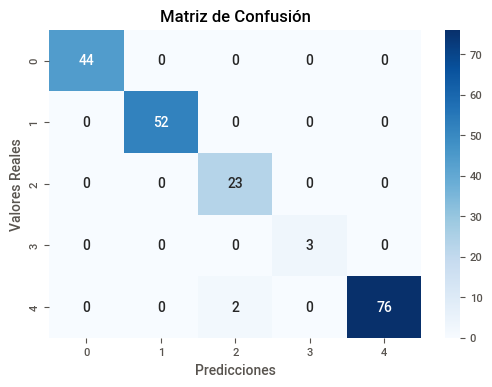

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        52
           3       0.92      1.00      0.96        23
           4       1.00      1.00      1.00         3
           5       1.00      0.97      0.99        78

    accuracy                           0.99       200
   macro avg       0.98      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Importar el modelo seleccionado
from sklearn.ensemble import RandomForestClassifier  # Cambia esto según el mejor modelo

best_model = RandomForestClassifier()  # Instancia del modelo
best_model.fit(X_train, y_train)  # Entrenamiento

# Predicciones en test
y_pred = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred))

In [31]:
! pip install flaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 13.5 MB/s eta 0:00:00


## 3 flaml


In [32]:
from flaml import AutoML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



automl = AutoML()

#Training the models
automl.fit(X_train, y_train, task="classification")

[flaml.automl.logger: 03-18 20:02:54] {1728} INFO - task = classification
[flaml.automl.logger: 03-18 20:02:54] {1739} INFO - Evaluation method: cv


INFO:flaml.automl.task.generic_task:class 3 augmented from 19 to 38


[flaml.automl.logger: 03-18 20:02:54] {1838} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 03-18 20:02:54] {1861} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.


INFO:flaml.default.suggest:metafeature distance: 0.1666731026712044
INFO:flaml.default.suggest:metafeature distance: 0.1666731026712044
INFO:flaml.default.suggest:metafeature distance: 0.16667311457788905
INFO:flaml.default.suggest:metafeature distance: 0.16667311457788905
INFO:flaml.default.suggest:metafeature distance: 0.16667311457788905
INFO:flaml.default.suggest:metafeature distance: 0.1666731026712044


[flaml.automl.logger: 03-18 20:02:54] {1955} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 03-18 20:02:54] {2258} INFO - iteration 0, current learner rf
[flaml.automl.logger: 03-18 20:03:53] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 03-18 20:03:53] {2442} INFO -  at 59.4s,	estimator rf's best error=0.0597,	best estimator rf's best error=0.0597
[flaml.automl.logger: 03-18 20:03:53] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-18 20:03:59] {2442} INFO -  at 65.1s,	estimator lgbm's best error=0.5076,	best estimator rf's best error=0.0597
[flaml.automl.logger: 03-18 20:03:59] {2258} INFO - iteration 2, current learner xgboost
[flaml.automl.logger: 03-18 20:05:17] {2442} INFO -  at 143.1s,	estimator xgboost's best error=0.0245,	best estimator xgboost's best error=0.0245
[flaml.automl.logger: 03-18 20:05

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 03-18 20:05:51] {2442} INFO -  at 177.5s,	estimator sgd's best error=1.4320,	best estimator xgb_limitdepth's best error=0.0235
[flaml.automl.logger: 03-18 20:05:51] {2258} INFO - iteration 6, current learner lrl1


INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 03-18 20:05:51] {2442} INFO -  at 177.9s,	estimator lrl1's best error=1.3812,	best estimator xgb_limitdepth's best error=0.0235
[flaml.automl.logger: 03-18 20:05:52] {2685} INFO - retrain xgb_limitdepth for 0.6s
[flaml.automl.logger: 03-18 20:05:52] {2688} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.4814471959023239, colsample_bynode=None,
              colsample_bytree=0.6050207253592859, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07962498837600937,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=0.0068282719220722, missing=nan,
              monotone_constr

In [ ]:
automl.best_estimator

'extra_tree'

In [ ]:
automl.best_config

{'n_estimators': 2047,
 'max_features': 1.0,
 'max_leaves': 18344,
 'criterion': 'entropy'}

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      0.94      0.94        18
           2       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



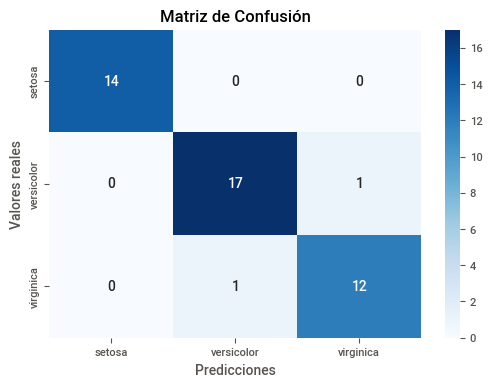

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones en el conjunto de prueba
y_pred = automl.predict(X_test)

# Reporte de clasificación
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_endcoder.classes_, yticklabels=label_endcoder.classes_)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()
